In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio
from sklearn.metrics import average_precision_score, precision_recall_curve
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

In [4]:
def odds_ratio_score(y_true, y_pred, threshold_q=0.05):
    df = pl.DataFrame({"label": y_true, "score": -y_pred})
    threshold = df.select(pl.col("score").quantile(threshold_q))["score"]
    # TODO: need to decide how to handle ties... they are certainly an issue with phastCons
    #if threshold_q == 0.05:
    #    print((df["score"] <= threshold).sum())
    group_counts = (
        df.group_by(["label", pl.col("score") <= threshold]).len()
        .sort(["label", "score"])["len"].to_numpy().reshape((2,2))
    )
    #if threshold_q == 0.05:
    #    print(group_counts)
    res = odds_ratio(group_counts, kind="sample")
    ci = res.confidence_interval(confidence_level=0.95)
    return res.statistic, ci.low, ci.high

In [16]:
datasets = [
    #"de_novo_v3/5_prime_UTR_variant/9",
    #"de_novo_v3/3_prime_UTR_variant/9",
    #"de_novo_v3/upstream_gene_variant/9",
    #"de_novo_v3/non_coding_transcript_exon_variant/9",
    #"de_novo_v2",
    #"de_novo_v4/9",
    #"de_novo_v4_all",
    "de_novo_v5/9",
    #"de_novo_v5_all",
]

models = [
    "gpnmsa",
    "CADD_RawScore",
    #"phyloP-100v",
    #"phyloP-241m",
    #"phastCons-43p",
    "phyloP-100v_noimputation",
    "phyloP-241m_noimputation",
    "phastCons-43p_noimputation",
]

model_renaming = {
    "gpnmsa": "GPN-MSA",
    "CADD_RawScore": "CADD",
    "phyloP-100v_noimputation": "phyloP-100v",
    "phyloP-241m_noimputation": "phyloP-241m",
    "phastCons-43p_noimputation": "phastCons-43p",
}

def load_dataset(dataset):
    V = pl.read_parquet(f"../../results/dataset/{dataset}/test.parquet")
    for model in models:
        V = V.with_columns(
            pl.read_parquet(f"../../results/dataset/{dataset}/features/{model}.parquet")["score"].alias(model_renaming.get(model, model))
        )
    return V

V = pl.concat((load_dataset(dataset) for dataset in datasets))
models = [model_renaming.get(model, model) for model in models]
print(V.select(models).null_count())
V = V.drop_nulls(models)
V

shape: (1, 5)
┌─────────┬──────┬─────────────┬─────────────┬───────────────┐
│ GPN-MSA ┆ CADD ┆ phyloP-100v ┆ phyloP-241m ┆ phastCons-43p │
│ ---     ┆ ---  ┆ ---         ┆ ---         ┆ ---           │
│ u32     ┆ u32  ┆ u32         ┆ u32         ┆ u32           │
╞═════════╪══════╪═════════════╪═════════════╪═══════════════╡
│ 0       ┆ 0    ┆ 2           ┆ 1           ┆ 1             │
└─────────┴──────┴─────────────┴─────────────┴───────────────┘


chrom,consequence,pos,ref,alt,label,trait,AF,FILTER,MR,match_group,GPN-MSA,CADD,phyloP-100v,phyloP-241m,phastCons-43p
str,str,i64,str,str,bool,str,f64,str,f64,i64,f32,f32,f64,f64,f64
"""1""","""5_prime_UTR_variant""",925734,"""G""","""A""",false,null,0.0,"""TFBS""",0.128,350,1.98,1.223687,1.755,0.981,0.075
"""1""","""5_prime_UTR_variant""",1632192,"""A""","""C""",false,null,0.0,"""TFBS""",0.041,352,0.82,1.02055,-0.617,0.396,0.947
"""1""","""5_prime_UTR_variant""",2556092,"""A""","""C""",false,null,0.0,"""TFBS""",0.02,348,0.21,0.322761,0.005,-0.181,0.003
"""1""","""upstream_gene_variant""",2968933,"""C""","""T""",false,null,0.0,"""TFBS""",0.117,383,1.11,0.182129,-0.31,0.322,0.013
"""1""","""upstream_gene_variant""",3612457,"""G""","""A""",false,null,0.0,"""TFBS""",0.186,377,1.27,0.302547,0.062,0.256,0.002
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""22""","""3_prime_UTR_variant""",40832178,"""C""","""T""",false,null,0.0,"""TFBS""",0.105,392,1.28,0.476308,-0.016,0.118,0.002
"""22""","""3_prime_UTR_variant""",41598715,"""C""","""A""",false,null,0.0,"""TFBS""",0.128,392,-1.07,0.129669,0.308,-0.058,0.002
"""22""","""3_prime_UTR_variant""",42619640,"""A""","""T""",false,null,0.0,"""TFBS""",0.02,392,2.92,0.331386,1.302,0.522,0.0


In [17]:
V["label"].mean()

0.10007047216349542

In [10]:
or_pcts = [
    0.1,
    1,
    10,
]

or_pct_cols = [f"OR@{or_pct}" for or_pct in or_pcts]

res = []
for model in tqdm(models):
    y_true = V["label"]
    y_pred = V[model]
    res.append((
        model,
        average_precision_score(y_true, y_pred),
        *[odds_ratio_score(y_true, y_pred, or_pct / 100) for or_pct in or_pcts]
    ))
res = pd.DataFrame(res, columns=["model", "AUPRC"] + or_pct_cols)
res

100%|██████████| 5/5 [00:27<00:00,  5.56s/it]


,model,AUPRC,OR@0.1,OR@1,OR@10
0,GPN-MSA,0.004864,"(195.5911952555366, 151.30739946427232, 252.83...","(75.04524691441313, 61.9497485457298, 90.90899...","(18.475047265253828, 15.087665591578112, 22.62..."
1,CADD,0.000940,"(49.26707288773102, 31.43962117017149, 77.2033...","(73.21802939557521, 60.41749679568169, 88.7305...","(31.79343577176853, 25.28629063773773, 39.9751..."
2,phyloP-100v,0.001311,"(115.32388192856442, 84.38080110530016, 157.61...","(54.39479772076617, 44.598125566224674, 66.343...","(12.051181962666563, 9.946203103852094, 14.601..."
3,phyloP-241m,0.001233,"(98.05772434835059, 70.24929533442248, 136.874...","(99.0877597026747, 81.94289147093225, 119.8198...","(20.722828040513924, 16.853502213577464, 25.48..."
4,phastCons-43p,0.000475,"(45.51803406434376, 35.2758055426089, 58.73406...","(39.13189696743539, 31.892810206364906, 48.014...","(22.13581714089703, 17.950984511911827, 27.296..."


<Axes: xlabel='model', ylabel='AUPRC'>

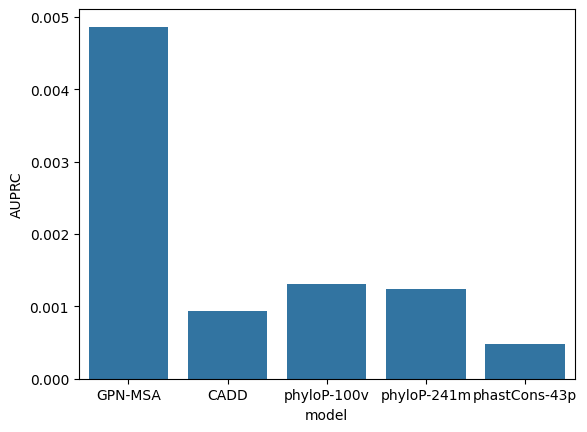

In [11]:
# TODO: should get AUPRC error bars
sns.barplot(data=res, x="model", y="AUPRC")

In [12]:
# Reshape the data from wide to long format for plotting using pandas.melt
res_long = res.melt(
    id_vars="model",
    value_vars=or_pct_cols,
    var_name="%",
    value_name="OR_CI",
)

# Extract OR and CI values into separate columns
# The .str accessor provides an efficient way to split tuples in a Series
res_long['OR'] = res_long['OR_CI'].str[0]
res_long['ci_low'] = res_long['OR_CI'].str[1]
res_long['ci_high'] = res_long['OR_CI'].str[2]
res_long

,model,%,OR_CI,OR,ci_low,ci_high
0,GPN-MSA,OR@0.1,"(195.5911952555366, 151.30739946427232, 252.83...",195.591195,151.307399,252.835722
1,CADD,OR@0.1,"(49.26707288773102, 31.43962117017149, 77.2033...",49.267073,31.439621,77.203363
2,phyloP-100v,OR@0.1,"(115.32388192856442, 84.38080110530016, 157.61...",115.323882,84.380801,157.614026
3,phyloP-241m,OR@0.1,"(98.05772434835059, 70.24929533442248, 136.874...",98.057724,70.249295,136.874217
4,phastCons-43p,OR@0.1,"(45.51803406434376, 35.2758055426089, 58.73406...",45.518034,35.275806,58.734064
5,GPN-MSA,OR@1,"(75.04524691441313, 61.9497485457298, 90.90899...",75.045247,61.949749,90.908990
6,CADD,OR@1,"(73.21802939557521, 60.41749679568169, 88.7305...",73.218029,60.417497,88.730585
7,phyloP-100v,OR@1,"(54.39479772076617, 44.598125566224674, 66.343...",54.394798,44.598126,66.343461
8,phyloP-241m,OR@1,"(99.0877597026747, 81.94289147093225, 119.8198...",99.087760,81.942891,119.819840
9,phastCons-43p,OR@1,"(39.13189696743539, 31.892810206364906, 48.014...",39.131897,31.892810,48.014125


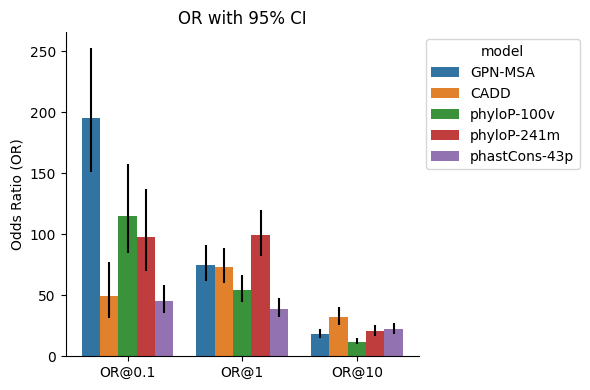

In [13]:
# 1. Create the bar plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=res_long, x="%", y="OR", hue="model")

# 2. Add custom error bars robustly
for bar in ax.patches:
    # --- THIS IS THE FIX ---
    # Ignore invisible "ghost" patches that seaborn sometimes creates
    if bar.get_height() == 0 and bar.get_width() == 0:
        continue

    # Get the bar's color to identify its hue
    bar_color = bar.get_facecolor()

    # Get the x-tick label for the bar
    x_tick_index = int(round(bar.get_x() + bar.get_width() / 2))
    x_tick_label = ax.get_xticklabels()[x_tick_index].get_text()

    # Get the handles for the legend
    legend_handles, _ = ax.get_legend_handles_labels()

    hue_label = ""
    for handle in legend_handles:
        # Use the .patches[0] version for robustness across matplotlib versions
        if handle.get_facecolor() == bar_color:
            hue_label = handle.get_label()
            break

    # Find the corresponding data row in the DataFrame
    data_row = res_long[(res_long['model'] == hue_label) & (res_long['%'] == x_tick_label)]

    if data_row.empty:
        continue

    # Extract data from the correctly identified row
    ci_low = data_row['ci_low'].iloc[0]
    ci_high = data_row['ci_high'].iloc[0]

    # Use the bar's actual height for y-position and calculation
    bar_height = bar.get_height()

    # Calculate error bar magnitudes
    lower_error = bar_height - ci_low
    upper_error = ci_high - bar_height

    # Ensure errors are positive
    if lower_error < 0: lower_error = 0
    if upper_error < 0: upper_error = 0

    # Get the x-coordinate for the error bar
    x_coord = bar.get_x() + bar.get_width() / 2

    # Plot the correctly aligned error bar
    ax.errorbar(x=x_coord, y=bar_height, yerr=[[lower_error], [upper_error]],
                fmt='none',
                c='black')

# --- Final Touches ---
# Use ax.set_ylim() for setting y-axis limits
ax.set_ylim(bottom=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("OR with 95% CI")
ax.set_ylabel("Odds Ratio (OR)")
ax.set_xlabel("")
sns.despine()
plt.tight_layout()
plt.show()

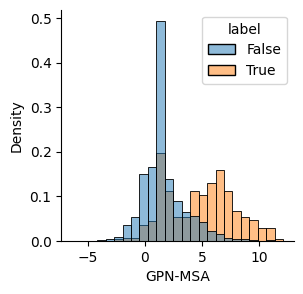

In [154]:
plt.figure(figsize=(3, 3))
sns.histplot(
    data=V,
    x="GPN-MSA",
    hue="label",
    stat="density",
    common_norm=False,
    common_bins=True,
    bins=25,
)
sns.despine();

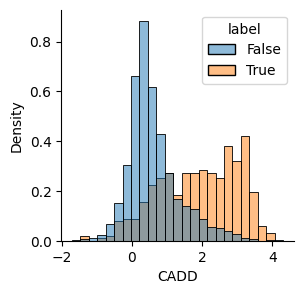

In [155]:
plt.figure(figsize=(3, 3))
sns.histplot(
    data=V,
    x="CADD",
    hue="label",
    stat="density",
    common_norm=False,
    common_bins=True,
    bins=25,
)
sns.despine();

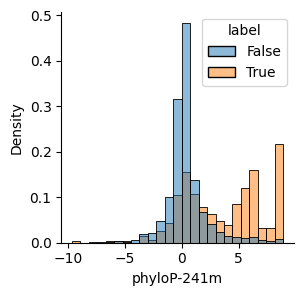

In [156]:
plt.figure(figsize=(3, 3))
sns.histplot(
    data=V,
    x="phyloP-241m",
    hue="label",
    stat="density",
    common_norm=False,
    common_bins=True,
    bins=25,
)
sns.despine();

In [18]:
#def my_ap_at_k(df, col_true, col_pred, n=100):
#    labels = df.sort(col_pred, descending=True).head(n)[col_true]
#    res = np.mean([
#        labels[:i+1].mean()
#        for i in np.where(labels)[0]
#    ])
#    return res


def my_ap_at_k(df, col_true, col_pred, n=100):
    labels = df.sort(col_pred, descending=True).head(n)[col_true]
    res = np.mean([
        labels[:i+1].mean()
        for i in range(n)
    ])
    return res


my_ap_at_k(V, "label", "GPN-MSA", 100)

0.8132370091193161

In [19]:
# I guess we want to average preciosion@N for N=1...M
# potentially weighted?
# see here:
# https://stackoverflow.com/questions/55748792/understanding-precisionk-apk-mapk

for model in models:
    print(
        model,
        #my_ap_at_k(V, "label", model, 100),
        my_ap_at_k(V, "label", model, len(V) // 10),
        #my_ap_at_k(V, "label", model, len(V)),
    )

GPN-MSA 0.6294981748670616
CADD 0.6056065941729781
phyloP-100v 0.6235979106273429
phyloP-241m 0.614004050209348
phastCons-43p 0.3756816046232286


In [27]:
palette = {
    "GPN-MSA": "C0",
    "CADD": "C1",
    "phyloP": "C2",
    "ESM-1b": "C3",
    "NT": "C4",
    "SpliceAI": "C5",
    "Enformer": "C6",
    "HyenaDNA": "C9",
    
    "phyloP-100v": "C2",
    "phyloP-241m": "C7",
    "phastCons-100v": "C8",

    "phastCons-43p": "C9",

    "NT-500m-human-ref": "gray",
    "NT-500m-1000g": "gray",
    "NT-2.5b-1000g": "gray",
    "NT-2.5b-multi-species": "C4",
    
    r"Enformer ($L^1$)": "C6",
    r"Enformer ($L^2$)": "C7",
    r"Enformer ($L^\infty$)": "C8",
    
    "PrimateAI-3D": "black",
    
    "pLI": "C6",
    r"$hs$": "C9",
    "GeneBayes": "teal",
}

In [35]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

def plot_curve(V, results, curve, xlim=None):
    n_pos, n_neg = V["label"].sum(), (~V["label"]).sum()
    if curve == "ROC":
        plot_f = RocCurveDisplay
        metric = "AUROC"
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        random_plot = lambda ax: ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
    elif curve == "PR":
        pos_prop = n_pos / (n_pos + n_neg)
        plot_f = PrecisionRecallDisplay
        metric = "AUPRC"
        xlabel = 'Recall'
        ylabel = 'Precision'
        random_plot = lambda ax: ax.axhline(y=pos_prop, linestyle="--", color="gray")
    
    # note: latest sklearn has argument: plot_chance_level
    fig, ax = plt.subplots(figsize=(8,8))

    for m in results.model.unique()[::-1]:
        AUC = results[results.model==m].iloc[0][metric]
        plot_f.from_predictions(V.label, V[m], name=m, ax=ax, label=f"{m} (AUC={AUC:.3f})", color=palette[m])
        
    random_plot(ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    sns.despine()
    
    ax.legend();
    # get handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # reverse the order
    handles, labels = handles[::-1], labels[::-1]
    # create the legend with the reversed order
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    if xlim is not None:
        plt.xlim(-0.01, xlim)

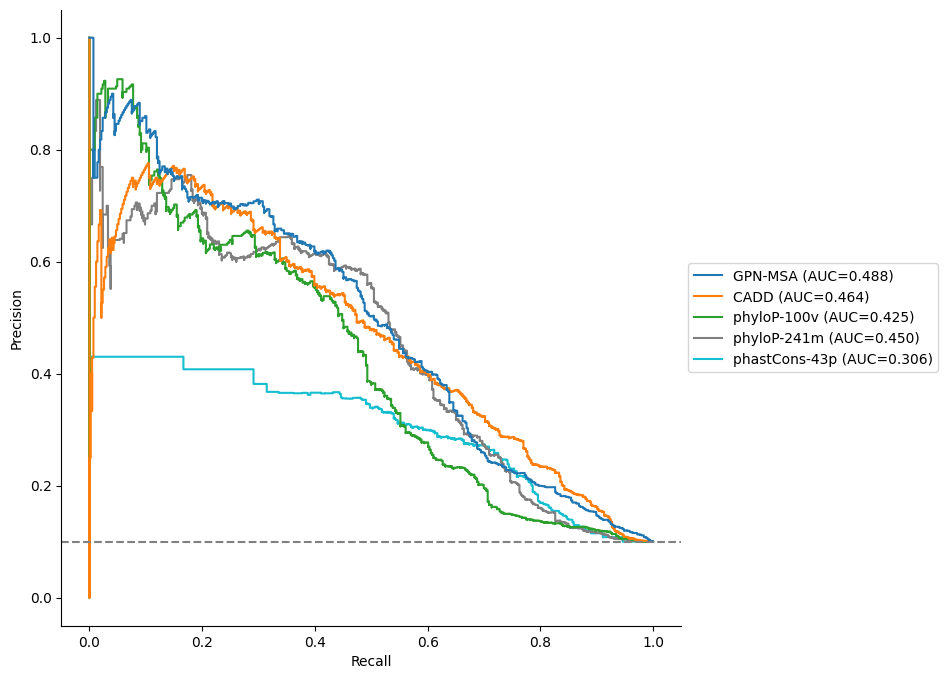

In [36]:
plot_curve(V.to_pandas(), res, "PR")

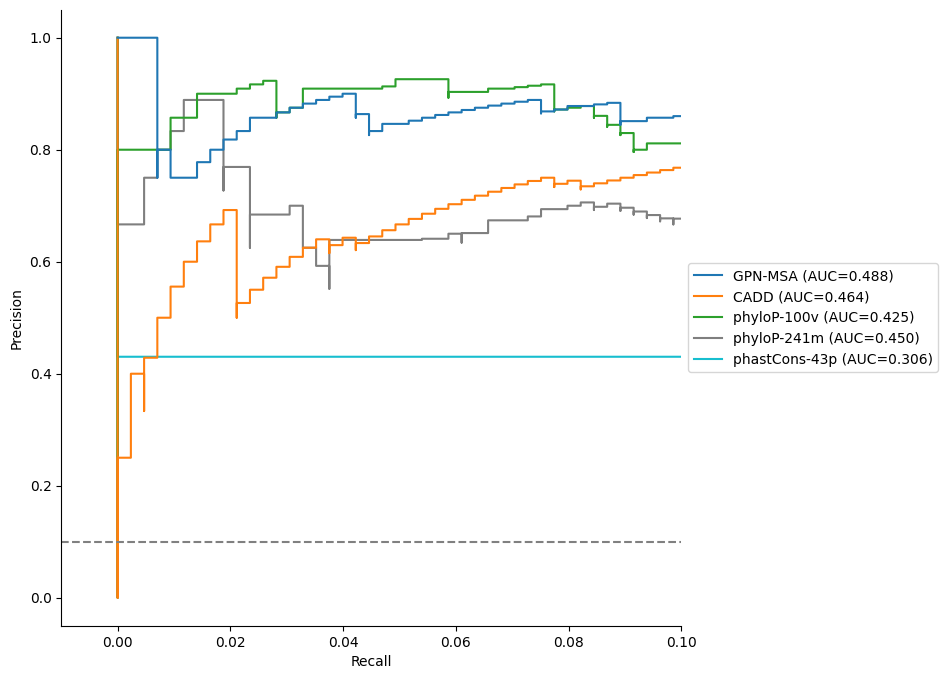

In [37]:
plot_curve(V.to_pandas(), res, "PR", 0.1)

In [40]:
V.sort("GPN-MSA", descending=True).head(100)["label"].to_numpy()

array([ True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True, False,  True,  True,  True,  True,  True, False, False,
       False, False,  True, False,  True, False, False,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False,  True,  True, False, False,  True,  True,  True, False,
        True,  True,  True, False, False, False,  True,  True, False,
        True])

In [41]:
V.sort("CADD", descending=True).head(100)["label"].to_numpy()

array([False, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True, False, False,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True, False,
        True,  True,  True,  True, False, False,  True, False,  True,
       False])